In [2]:
## Import Libraries

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

# File management
import os
from zipfile import ZipFile
from tensorflow.keras.utils import image_dataset_from_directory

# Import relevant libraries
import PIL
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Rescaling
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

%matplotlib inline

2023-01-16 11:14:45.335533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Obtain the dataset 
Considering the size of the dataset, we will remotely obtain the dataset, from kaggle repository.

[Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)

In [4]:
# https://www.kaggle.com/general/74235
repository_dir = os.getcwd()
zip_filename = 'intel-image-classification.zip'
zip_file = os.path.join(repository_dir, zip_filename)
if not os.path.exists(zip_file):    
    # Install Kaggle
    !pip install -q kaggle
    # create folder ~/.kaggle, which is where kaggle will search for the API Token
    !rm -r ~/.kaggle
    !mkdir ~/.kaggle
    # move kaggle.json to ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    # Change the permissions of the file. 
    !chmod 600 ~/.kaggle/kaggle.json
    os.system("kaggle datasets download -d puneet6060/intel-image-classification")

 99%|█████████▉| 344M/346M [00:25<00:00, 19.8MB/s] 

100%|██████████| 346M/346M [00:25<00:00, 14.3MB/s]


## Get data

In [6]:
zip_ref = ZipFile(zip_file, 'r')
zip_ref.extractall(repository_dir)
zip_ref.close()

train_dir = os.path.join(repository_dir, "seg_train", "seg_train")
test_dir = os.path.join(repository_dir, "seg_test", "seg_test")

os.system(f"rm -r {os.path.join(repository_dir, 'seg_pred')}")

# load variables
validation_percentage = 0.2
label_mode = "int"
# for our model purposes
img_size = (224, 224)
color_mode='rgb'

data_train, data_val = image_dataset_from_directory(
    train_dir,
    batch_size=None,
    label_mode=label_mode,
    color_mode=color_mode,
    image_size=img_size,
    validation_split=validation_percentage,
    subset="both",
    seed=123,
)
data_test = image_dataset_from_directory(
    test_dir,
    batch_size=None,
    label_mode=label_mode,
    color_mode=color_mode,
    image_size=img_size,
)

classes = data_train.class_names
print(classes)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## Visualize data

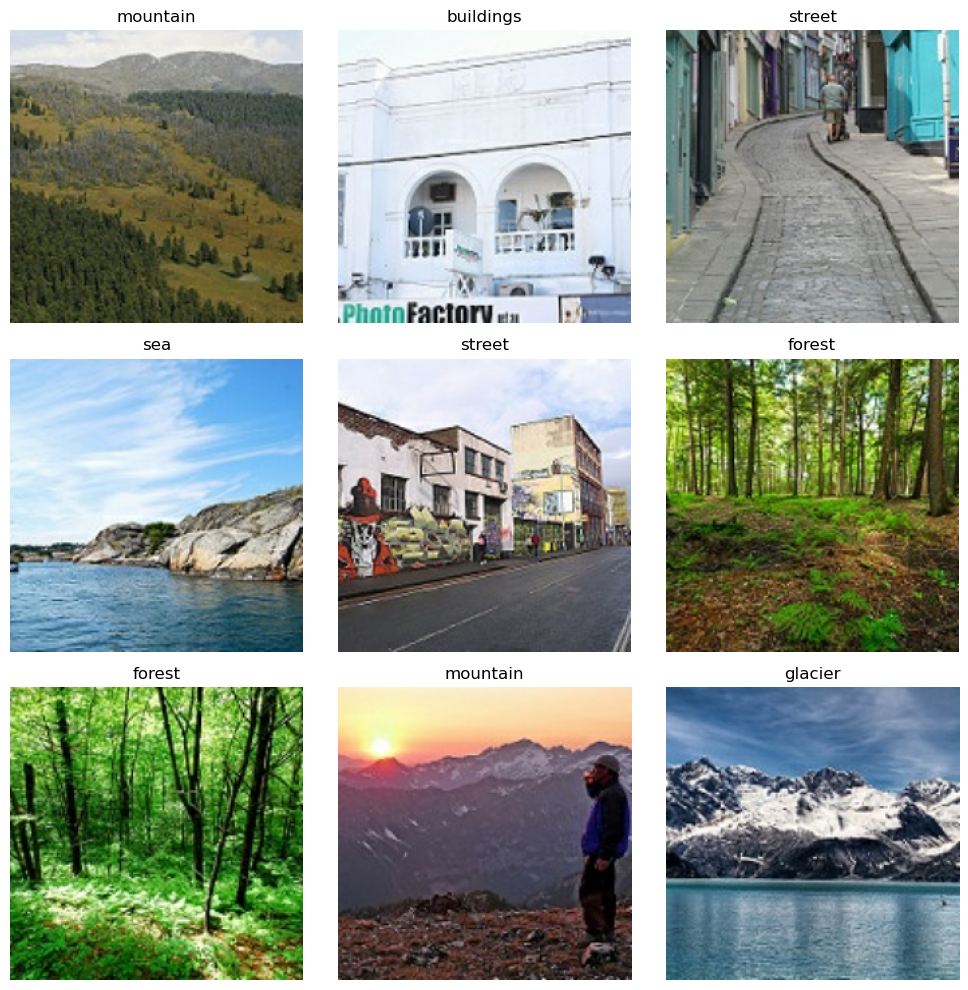

In [12]:
# from https://www.tensorflow.org/tutorials/load_data/images
fig, axes = plt.subplots(3, 3, figsize=(10,10))
axes = axes.flatten()

for i in range(9):
    ax = axes[i]
    elem = data_train.take(1)
    for image, label in elem.as_numpy_iterator():
        ax.imshow(image.astype("uint8"))
        ax.set_title(classes[label])
    ax.axis('off')
plt.tight_layout()
plt.show()

## Model number 01 - VGG-16
The VGG-16 is one of the most popular pre-trained models for image classification. Introduced in the famous 
ILSVRC 2014 Conference, it was and remains THE model to beat even today. Developed at the Visual Graphics 
Group at the University of Oxford, VGG-16 beat the then standard of AlexNet and was quickly adopted by 
researchers and the industry for their image Classification Tasks.
https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

trainable = False

## Preprocessing Image
rescaling = 1.0/255<br>
No necessary augmenting data besides image resizing and rescale normalization.

In [13]:
scale = 1.0/255
normalization_layer = tf.keras.layers.Rescaling(scale)
data_train_norm = data_train.map(lambda x,y: (normalization_layer(x), y))
data_val_norm = data_val.map(lambda x,y: (normalization_layer(x), y))
data_test_norm = data_test.map(lambda x,y: (normalization_layer(x), y))

## Creating the model

In [24]:
from tensorflow.keras.applications.vgg16 import VGG16

input_size = None
for img, label in data_train_norm.take(1).as_numpy_iterator():
    input_size = img.shape
print(input_size)

base_model = VGG16(
    input_shape=input_size, # Shape of our images
    include_top = False, # Leave out the last fully connected layer
    weights = 'imagenet'
)

# we do not train the parameters
for layer in base_model.layers:
    layer.trainable = False

(224, 224, 3)


In [25]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# https://medium.com/analytics-vidhya/car-brand-classification-using-vgg16-transfer-learning-f219a0f09765
# FC layer very simple and with a softmax activation unit
x = layers.Dense(len(classes), activation="softmax")(x)

landscapeModel01 = Model(inputs=base_model.input, outputs=x, name="landscapeModel01")

In [27]:
loss = "sparse_categorical_crossentropy" #Unvariable, considering the data phenomenum
optimizer = "adam" # Variable

landscapeModel01.compile(
    optimizer=optimizer, 
    loss=loss,
    metrics=["accuracy"]
)


landscapeModel01.summary()

Model: "landscapeModel01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)  

In [28]:
#fit data
shuffle=True # variable
epochs=50 # variable, according if it is able to converge
batch_size = 200

print(landscapeModel01.input)

landscapeModel01.fit(
    data_train_norm,
    validation_data=data_val_norm,
    epochs=epochs,
    shuffle=shuffle,
    batch_size=batch_size
)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
Epoch 1/50


ValueError: in user code:

    File "/home/renan/anaconda3/envs/faa/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/renan/anaconda3/envs/faa/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/renan/anaconda3/envs/faa/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/renan/anaconda3/envs/faa/lib/python3.10/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/home/renan/anaconda3/envs/faa/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/renan/anaconda3/envs/faa/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "landscapeModel01" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(224, 224, 3)
